<a href="https://colab.research.google.com/github/ShrutiKharate/YOLO5_pedestrian-detection/blob/main/YOLOv5_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# YOLOv5 Pedestrian Detection
This notebook is a **beginner-friendly, runnable solution** for implementing YOLOv5 on an **already-annotated YOLOv5-format dataset** (recommended via **Roboflow Universe**).

## What you will do
1. Enable GPU and verify it
2. Clone YOLOv5 and install requirements
3. Download a YOLOv5-ready dataset (Roboflow)
4. Train a baseline YOLOv5 model
5. Validate and record metrics
6. Run inference and visualize results
7. (Optional) Export and zip outputs for submission

> **Note:** You only need to paste your Roboflow API key + project details in the dataset cell.

## 0) Runtime Setup (GPU)

**Colab:** `Runtime → Change runtime type → GPU`

Then run the next cell to verify GPU.

In [11]:
!nvidia-smi

Mon Jan  5 08:30:51 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   38C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## 1) Clone YOLOv5 and Install Dependencies

This will download the official YOLOv5 repo and install required packages.

In [12]:
!git clone https://github.com/ultralytics/yolov5
%cd yolov5
# !pip install -r requirements.txt

Cloning into 'yolov5'...
remote: Enumerating objects: 17778, done.
remote: Counting objects: 100% (153/153), done.
remote: Compressing objects: 100% (103/103), done.
remote: Total 17778 (delta 97), reused 50 (delta 50), pack-reused 17625 (from 3)
Receiving objects: 100% (17778/17778), 17.09 MiB | 30.33 MiB/s, done.
Resolving deltas: 100% (12074/12074), done.
/content/yolov5/yolov5


## 2) Configuration (Edit if needed)

- `RUN_NAME`: experiment name (output folder name)
- `IMG`: input resolution (640 is a strong baseline)
- `EPOCHS`: 30 for beginner baseline
- `BATCH`: start with 16, reduce to 8 if GPU memory error

In [13]:
RUN_NAME = "ped_beginner"
IMG = 640
EPOCHS = 30
BATCH = 16  # reduce to 8 if you get CUDA OOM

## 3) Download a YOLOv5-ready Dataset (Roboflow Universe)

### Steps (do once)
1. Go to **Roboflow Universe**
2. Search: **pedestrian detection** or **person detection**
3. Open a dataset that has bounding-box annotations
4. Click **Download Dataset**
5. Choose format: **YOLOv5 PyTorch**
6. Copy the code snippet and paste into the cell below

> The snippet will automatically create a folder like `/content/<dataset-name>/` containing `data.yaml`.

In [14]:
# Install Roboflow (only required if you use Roboflow download)
!pip -q install roboflow

In [15]:
!pip install roboflow

In [10]:
from roboflow import Roboflow
# CHANGE THIS LINE in your Roboflow cell:

# ---- PASTE YOUR ROBOTFLOW DETAILS HERE ----
rf = Roboflow(api_key="ABZ61UG80r3lECyV7ctD")
project = rf.workspace("disertation-project").project("personnormal")

version = project.version(1)

dataset = version.download("yolov5")

                  # change version if needed

print("Dataset downloaded to:", dataset.location)

loading Roboflow workspace...
loading Roboflow project...
Dataset downloaded to: /content/yolov5/PersonNormal-1


## 4) Verify Dataset Structure

This checks:
- `data.yaml` exists
- train/valid images and labels exist and counts look reasonable

If your dataset uses `valid/` (Roboflow default), YOLOv5 will handle it via `data.yaml`.

In [16]:
import os, glob, yaml

DATASET_DIR = dataset.location  # from Roboflow download
DATA_YAML = os.path.join(DATASET_DIR, "data.yaml")

print("DATASET_DIR:", DATASET_DIR)
print("data.yaml exists:", os.path.exists(DATA_YAML))

# Count files
def count_files(pat):
    return len(glob.glob(pat))

print("train/images:", count_files(os.path.join(DATASET_DIR, "train", "images", "*")))
print("train/labels:", count_files(os.path.join(DATASET_DIR, "train", "labels", "*")))
print("valid/images:", count_files(os.path.join(DATASET_DIR, "valid", "images", "*")))
print("valid/labels:", count_files(os.path.join(DATASET_DIR, "valid", "labels", "*")))

# Print class names from YAML
with open(DATA_YAML, "r") as f:
    y = yaml.safe_load(f)
print("\nYAML keys:", list(y.keys()))
print("Class names:", y.get("names", "NOT FOUND"))
print("nc:", y.get("nc", "NOT FOUND"))

DATASET_DIR: /content/yolov5/PersonNormal-1
data.yaml exists: True
train/images: 783
train/labels: 783
valid/images: 72
valid/labels: 72

YAML keys: ['names', 'nc', 'roboflow', 'test', 'train', 'val']
Class names: ['Person']
nc: 1


## 5) Train YOLOv5 (Baseline)

We train `yolov5s.pt` (small) for speed + good baseline.

Outputs will be saved under:
- `runs/train/<RUN_NAME>/`
- best weights: `runs/train/<RUN_NAME>/weights/best.pt`

In [19]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 29.1 MB/s eta 0:00:00


In [20]:
import os
import yaml
from ultralytics.utils.patches import torch_load

# 1. Setup the Correct Paths
# Ensure this matches the folder name in your Colab sidebar
DATASET_ROOT = '/content/yolov5/PersonNormal-1'
YAML_PATH = os.path.join(DATASET_ROOT, 'data.yaml')

# 2. Check the actual folder names on your disk
existing_folders = os.listdir(DATASET_ROOT)
# This line automatically detects if it's 'val' or 'valid'
val_folder_name = 'valid' if 'valid' in existing_folders else 'val'

print(f"Checking structure... Found '{val_folder_name}' folder for validation.")

# 3. Create a Perfect YAML Configuration
# We use absolute paths (starting with /content/) so YOLO never gets lost
data_config = {
    'path': DATASET_ROOT,
    'train': 'train/images',
    'val': f'{val_folder_name}/images',
    'test': 'test/images',
    'nc': 1,
    'names': ['pedestrian']
}

# 4. Write the fixed YAML
with open(YAML_PATH, 'w') as f:
    yaml.dump(data_config, f, default_flow_style=False)

print(f"✅ data.yaml successfully fixed at: {YAML_PATH}")

# 5. Define Training Variables
IMG = 640
BATCH = 16
EPOCHS = 30
RUN_NAME = "pedestrian_beginner_run"

# 6. Disable W&B and START TRAINING
os.environ["WANDB_MODE"] = "disabled"
%cd /content/yolov5

!python train.py \
  --img {IMG} \
  --batch {BATCH} \
  --epochs {EPOCHS} \
  --data "{YAML_PATH}" \
  --weights yolov5s.pt \
  --name "{RUN_NAME}" \
  --cache

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Checking structure... Found 'valid' folder for validation.
✅ data.yaml successfully fixed at: /content/yolov5/PersonNormal-1/data.yaml
/content/yolov5
wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
2026-01-05 08:34:34.214235: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1767602074.234479    2445 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been reg

## 6) Validate the Model (Official Metrics)

This prints:
- Precision
- Recall
- mAP@0.5
- mAP@0.5:0.95

In [21]:
BEST_WEIGHTS = f"runs/train/{RUN_NAME}/weights/best.pt"
print("Best weights exist:", os.path.exists(BEST_WEIGHTS), BEST_WEIGHTS)

!python val.py \
  --weights "{BEST_WEIGHTS}" \
  --data "{DATA_YAML}" \
  --img {IMG}

Best weights exist: True runs/train/pedestrian_beginner_run/weights/best.pt
val: data=/content/yolov5/PersonNormal-1/data.yaml, weights=['runs/train/pedestrian_beginner_run/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-453-geed9bc19 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
val: Scanning /content/yolov5/PersonNormal-1/valid/labels.cache... 72 images, 0 backgrounds, 0 corrupt: 100% 72/72 [00:00<?, ?it/s]
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100% 3/3 [00:03<00:00,  1.12s/it]
                   all         72        280      0.937      0.904      0.951      0.58

## 7) Inference on Validation Images (Save Predictions)

We run inference on the validation images and save:
- images with bounding boxes
- YOLO-format prediction label files with confidence scores (`--save-txt --save-conf`)

Outputs:
- `runs/detect/<DET_NAME>/`
- predicted labels: `runs/detect/<DET_NAME>/labels/`

In [22]:
DET_NAME = "ped_infer"

VALID_IMAGES = os.path.join(DATASET_DIR, "valid", "images")
print("Valid images path:", VALID_IMAGES)

!python detect.py \
  --weights "{BEST_WEIGHTS}" \
  --source "{VALID_IMAGES}" \
  --img {IMG} \
  --conf 0.25 \
  --iou 0.45 \
  --save-txt --save-conf \
  --name "{DET_NAME}"

Valid images path: /content/yolov5/PersonNormal-1/valid/images
detect: weights=['runs/train/pedestrian_beginner_run/weights/best.pt'], source=/content/yolov5/PersonNormal-1/valid/images, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_format=0, save_csv=False, save_conf=True, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=ped_infer, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-453-geed9bc19 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
image 1/72 /content/yolov5/PersonNormal-1/valid/images/crop001024_jpg.rf.0c2bd9b21b35b5f0f11001940f0c19d3.jpg: 640x640 1 pedestrian, 11.4ms
image 2/72 /content/yolov5/PersonNormal-1/valid/images/crop0010

## 8) Visualize 6 Predicted Images (3 easy + 3 difficult)

This displays the first 6 predicted images from the detect output folder.
You can change the selection logic if you want to manually pick difficult examples.

Total predicted images: 72


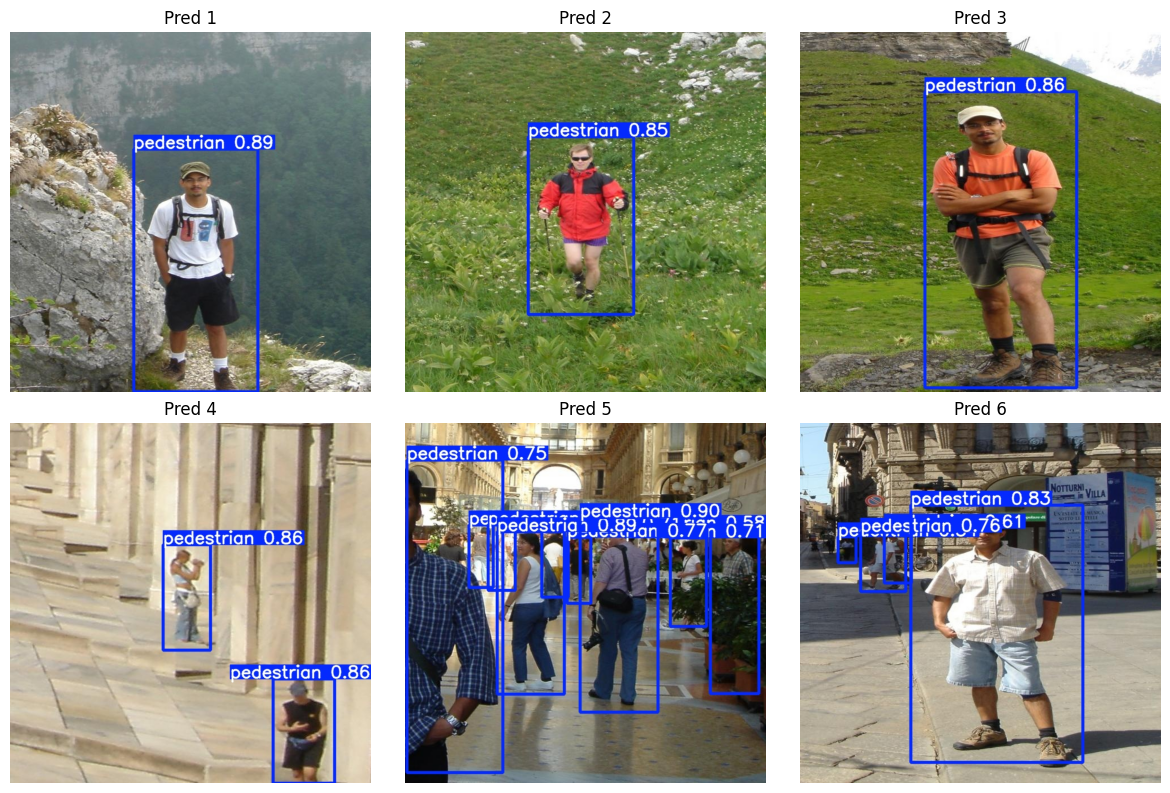

In [23]:
import glob
from PIL import Image
import matplotlib.pyplot as plt

pred_dir = f"/content/yolov5/runs/detect/{DET_NAME}"
imgs = sorted(glob.glob(os.path.join(pred_dir, "*.jpg")))

print("Total predicted images:", len(imgs))
show = imgs[:6]  # change if you want different ones

plt.figure(figsize=(12, 8))
for i, p in enumerate(show):
    plt.subplot(2, 3, i + 1)
    plt.imshow(Image.open(p))
    plt.axis("off")
    plt.title(f"Pred {i+1}")
plt.tight_layout()
plt.show()

## 9) Quick Beginner Observations (Write Your Answers)

Write 2–4 lines each (in a Markdown cell in your Colab):
1. What kind of pedestrians are detected well?
2. What kind are missed? (small / occluded / crowded)
3. More false positives or more misses?
4. If you want better small-pedestrian recall, what change would you try first?
5. If you want fewer false positives, which inference parameter would you increase?

## 10) (Optional) Export Model (ONNX) for Deployment

This creates an ONNX file you can use in deployment pipelines.

In [24]:
!python export.py \
  --weights "{BEST_WEIGHTS}" \
  --img {IMG} \
  --include onnx

export: data=data/coco128.yaml, weights=['runs/train/pedestrian_beginner_run/weights/best.pt'], imgsz=[640], batch_size=1, device=cpu, half=False, inplace=False, keras=False, optimize=False, int8=False, per_tensor=False, dynamic=False, cache=, simplify=False, mlmodel=False, opset=17, verbose=False, workspace=4, nms=False, agnostic_nms=False, topk_per_class=100, topk_all=100, iou_thres=0.45, conf_thres=0.25, include=['onnx']
YOLOv5 🚀 v7.0-453-geed9bc19 Python-3.12.12 torch-2.9.0+cu126 CPU

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs

PyTorch: starting from runs/train/pedestrian_beginner_run/weights/best.pt with output shape (1, 25200, 6) (13.8 MB)
requirements: Ultralytics requirements ['onnx>=1.12.0', 'onnxscript'] not found, attempting AutoUpdate...
Using Python 3.12.12 environment at: /usr
Resolved 8 packages in 137ms
Prepared 3 packages in 1.15s
Installed 3 packages in 286ms
 + onnx==1.20.0
 + onnx-ir==0.1.13
 + onnxscript==0.5.7

requir

## 11) (Optional) Zip Outputs for Submission

This creates a single zip containing:
- training run folder
- inference results
- exported model (if created)

You can download it from Colab.

In [25]:
import shutil, os

SUBMIT_DIR = "/content/assignment_yolov5_pedestrian"
os.makedirs(SUBMIT_DIR, exist_ok=True)

# Copy key folders
train_src = f"/content/yolov5/runs/train/{RUN_NAME}"
detect_src = f"/content/yolov5/runs/detect/{DET_NAME}"

train_dst = os.path.join(SUBMIT_DIR, "train_run")
detect_dst = os.path.join(SUBMIT_DIR, "detect_run")

# Remove old copies if they exist
for d in [train_dst, detect_dst]:
    if os.path.exists(d):
        shutil.rmtree(d)

shutil.copytree(train_src, train_dst)
shutil.copytree(detect_src, detect_dst)

# Copy data.yaml for reproducibility
shutil.copy2(DATA_YAML, os.path.join(SUBMIT_DIR, "data.yaml"))

# Zip
zip_path = shutil.make_archive("/content/assignment_yolov5_pedestrian", "zip", SUBMIT_DIR)
print("Created:", zip_path)

Created: /content/assignment_yolov5_pedestrian.zip


### Download the zip (Colab)

Run this cell to download the zip to your machine.

In [26]:
from google.colab import files
files.download("/content/assignment_yolov5_pedestrian.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [27]:
import os

# Path to the downloaded zip file
zip_file_path = "/content/assignment_yolov5_pedestrian.zip"

# Directory to extract the contents into
extraction_dir = "/content/extracted_yolov5_outputs"

# Create the extraction directory if it doesn't exist
os.makedirs(extraction_dir, exist_ok=True)

# Unzip the file
!unzip -o {zip_file_path} -d {extraction_dir}

print(f"Zip file extracted to: {extraction_dir}")
print("Contents of the extracted directory:")
!ls -F {extraction_dir}

Archive:  /content/assignment_yolov5_pedestrian.zip
   creating: /content/extracted_yolov5_outputs/detect_run/
   creating: /content/extracted_yolov5_outputs/train_run/
  inflating: /content/extracted_yolov5_outputs/data.yaml  
   creating: /content/extracted_yolov5_outputs/detect_run/labels/
  inflating: /content/extracted_yolov5_outputs/detect_run/person_234_jpg.rf.ab1180311ad1d174bd50495bd341eac3.jpg  
  inflating: /content/extracted_yolov5_outputs/detect_run/crop001560_jpg.rf.0d81a6ecc74b3f044bededb915b7dd05.jpg  
  inflating: /content/extracted_yolov5_outputs/detect_run/person_206_jpg.rf.7b7aba49268a24a9eb337b46232e85fe.jpg  
  inflating: /content/extracted_yolov5_outputs/detect_run/crop001706_jpg.rf.3feee08a5ab7ed5885211b08bf03032f.jpg  
  inflating: /content/extracted_yolov5_outputs/detect_run/person_and_bike_013_jpg.rf.01a7526fe977a5440b00caa77c092209.jpg  
  inflating: /content/extracted_yolov5_outputs/detect_run/person_and_bike_065_jpg.rf.dcaa1b60252088c163df32df720e30a1.jpg 